In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

In [2]:
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False, render_mode="rgb_array")
observation, info = env.reset()

In [3]:
env.action_space

Discrete(4)

In [4]:
env.observation_space

Discrete(64)

In [5]:
n_actions = env.action_space.n
n_states = env.observation_space.n

In [6]:
def render():
    state_image = env.render()
    plt.imshow(state_image)
    plt.show()

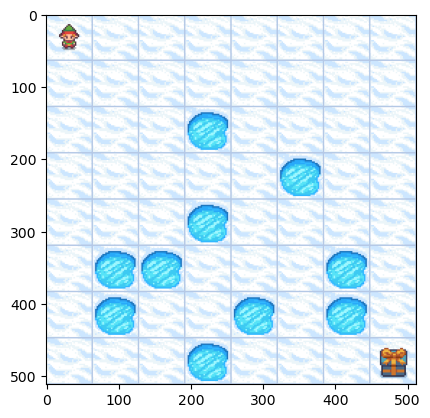

In [7]:
render()

In [8]:
env.unwrapped.desc

array([[b'S', b'F', b'F', b'F', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'F'],
       [b'F', b'F', b'F', b'F', b'F', b'H', b'F', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'F'],
       [b'F', b'H', b'H', b'F', b'F', b'F', b'H', b'F'],
       [b'F', b'H', b'F', b'F', b'H', b'F', b'H', b'F'],
       [b'F', b'F', b'F', b'H', b'F', b'F', b'F', b'G']], dtype='|S1')

In [9]:
chr(env.unwrapped.desc[0][0][0])

'S'

In [10]:
# To get the list of terminated states so as to remove them from the policy or Q as starting states.
ignore_list = []
for i in range(len(env.unwrapped.desc)):
    for j in range(len(env.unwrapped.desc[0])):
        if(chr(env.unwrapped.desc[i][j][0]) != 'F' and chr(env.unwrapped.desc[i][j][0]) != 'S'):
            print(i, j)
            ignore_list.append(8*i + j)

2 3
3 5
4 3
5 1
5 2
5 6
6 1
6 4
6 6
7 3
7 7


In [11]:
ignore_list

[19, 29, 35, 41, 42, 46, 49, 52, 54, 59, 63]

In [12]:
# A policy will be a state-action pair dictionary, which will dictate what action to take when youre in a given state.
# We will initialize our policy with random values for the sake of it.
# Policy contains actions for terminate states as well, we will ignore those in the future 
# policy = {state:env.action_space.sample() for state in range(n_states)}

In [13]:
# Q is an action-value pair dictionary, which dictates what is the total reward which my action will lead to if the policy is followed
# Q = {state: (action, compute_state_values(state, action)) for state in states for action in range(n_actions)} 

In [14]:
# We are going to use Any-Visit Monte Carlo
# So we will have 1 global Q table and another table to keep count of the number of times an action on a given state has been performed
Q_mc = np.zeros((n_states, n_actions))
rewards = np.zeros((n_states, n_actions))
visits = np.zeros((n_states, n_actions))
n_episodes = 100000

In [15]:
observation, info = env.reset()

In [16]:
# print(observation, info)
action = np.random.randint(0, 3)
next_state, reward, terminated, truncated, info = env.step(action)
print(next_state, action, reward, info)

0 0 0.0 {'prob': 1.0}


In [17]:
# To update rewards and visits accordingly
def update(state, action, reward):
    rewards[state][action] += reward
    visits[state][action] += 1

In [18]:
def run_episodes_monte_carlo(n_episodes):
    for _ in range(n_episodes):
        observation, info = env.reset()
        state = observation
    
        # Run the episode till termination
        while True:
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, info = env.step(action)     
            # To prevent wastage of time in executing actions which land agent on same block as they cant be executed
            if state == next_state:
                continue
            update(state, action, reward)
            state = next_state
            if (terminated or truncated): 
                break

# Update the Q_mc table after termination
def update_q_table_monte_carlo():
    for state in range(n_states):
        for action in range(n_actions):
            if visits[state][action] >= 1:
                Q_mc[state][action] =  rewards[state][action] / visits[state][action]

In [19]:
run_episodes_monte_carlo(n_episodes)
update_q_table_monte_carlo()
for i in range(n_states):
    for j in range(n_actions):
        if Q_mc[i][j] > 0:
            print(f"state {i} and action {j} has a reward of {Q_mc[i][j]}")

state 55 and action 1 has a reward of 1.0
state 62 and action 2 has a reward of 1.0


As we can see, Monte Carlo is not very efficient as even after 10k itterations it never reached the goal state, maybe it is because it is updating after every episode? Now we are going to try TD learning where we will update the Q table each step within the episode itself

In [20]:
# We are now going to implement SARSA
gamma = 0.9
alpha = 0.4
Q_sarsa = np.zeros((n_states, n_actions))

def update_q_table_sarsa(state, action, next_state, next_action, reward):
    old_value = Q_sarsa[state][action]
    new_value = Q_sarsa[next_state][next_action]

    Q_sarsa[state][action] = ((1-alpha) * old_value) + (alpha * (reward + gamma * new_value))

def run_episodes_sarsa(n_episodes):
    for _ in range(n_episodes):
        observation, info = env.reset()
        state = observation
        action = env.action_space.sample()
        
        # Run the episode till termination
        while True:
            next_state, reward, terminated, truncated, info = env.step(action)
            # To prevent an episode from accumalting one blocks reward till truncation as invalid actions are not classified as terminated or truncated
            if state == next_state:
                action = env.action_space.sample()
                continue
            next_action = env.action_space.sample()
            update_q_table_sarsa(state, action, next_state, next_action, reward)
            state, action = next_state, next_action
            if (terminated or truncated): 
                break

In [21]:
run_episodes_sarsa(n_episodes)
for i in range(n_states):
    for j in range(n_actions):
        if Q_sarsa[i][j] > 0:
            print(f"state {i} and action {j} has a reward of {Q_sarsa[i][j]}")

state 0 and action 1 has a reward of 8.659189489956249e-07
state 0 and action 2 has a reward of 8.693973762351448e-07
state 1 and action 0 has a reward of 5.433571378935814e-07
state 1 and action 1 has a reward of 1.8166791121469275e-06
state 1 and action 2 has a reward of 3.19542368525405e-06
state 2 and action 0 has a reward of 1.610913375400293e-06
state 2 and action 1 has a reward of 2.832347371501609e-06
state 2 and action 2 has a reward of 1.916482108331923e-05
state 3 and action 0 has a reward of 2.200350378454144e-06
state 3 and action 1 has a reward of 2.1919938192614683e-05
state 3 and action 2 has a reward of 7.02168429718722e-05
state 4 and action 0 has a reward of 2.4818782449331793e-05
state 4 and action 1 has a reward of 9.71240427287692e-05
state 4 and action 2 has a reward of 7.500397134962851e-05
state 5 and action 0 has a reward of 6.620434045089486e-05
state 5 and action 1 has a reward of 0.0003244189567949352
state 5 and action 2 has a reward of 9.442527955542538e-

In [22]:
# Policy will be {state:action} pair
def compute_policy(Q):
    policy = {}
    for state in range(n_states):
        # Find the action with the highest Q-value for each state
        best_action = max(range(n_actions), key=lambda action: Q[state][action])
        policy[state] = best_action
    return policy

In [23]:
policy_mc = compute_policy(Q_mc)
policy_sarsa = compute_policy(Q_sarsa)

In [24]:
gamma = 1

def compute_state_value(state, policy):
    terminated, truncated = False, False
    while not (terminated or truncated):
        if state in ignore_list:
          return 0
        action = policy[state]
        next_state, reward, terminated, truncated, info = env.step(action)
        return reward + gamma * compute_state_value(next_state, policy)
    return 0

In [25]:
def policy_evaluation(policy):
    V = {state: compute_state_value(state, policy) for state in range(n_states)}
    return V

In [26]:
V_mc = policy_evaluation(policy_mc)
V_sarsa = policy_evaluation(policy_sarsa)

In [27]:
V_mc

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0}

In [ ]:
# Policy evaluation for a stochastic environment is done by taking the avg of rewards across multiple episodes 
reward_per_learned_episode = []
for episode in range(10000):
    state, info = env.reset()
    terminated = False
    episode_reward = 0
    while not (terminated or truncated):
        action = policy[state]
        new_state, reward, terminated, truncated, info = env.step(action)
        state = new_state
        episode_reward += reward
    reward_per_learned_episode.append(episode_reward)

avg_reward_per_learned_episode = np.mean(reward_per_learned_episode)
print("Average reward per learned episode: ", avg_reward_per_learned_episode)

In [29]:
policy_sarsa

{0: 2,
 1: 2,
 2: 2,
 3: 2,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 2,
 9: 3,
 10: 2,
 11: 2,
 12: 2,
 13: 1,
 14: 2,
 15: 1,
 16: 3,
 17: 3,
 18: 3,
 19: 0,
 20: 2,
 21: 2,
 22: 2,
 23: 1,
 24: 2,
 25: 3,
 26: 2,
 27: 2,
 28: 3,
 29: 0,
 30: 1,
 31: 1,
 32: 2,
 33: 3,
 34: 3,
 35: 0,
 36: 2,
 37: 2,
 38: 2,
 39: 1,
 40: 3,
 41: 0,
 42: 0,
 43: 2,
 44: 2,
 45: 1,
 46: 0,
 47: 1,
 48: 3,
 49: 0,
 50: 2,
 51: 3,
 52: 0,
 53: 1,
 54: 0,
 55: 1,
 56: 3,
 57: 2,
 58: 3,
 59: 0,
 60: 2,
 61: 2,
 62: 2,
 63: 0}

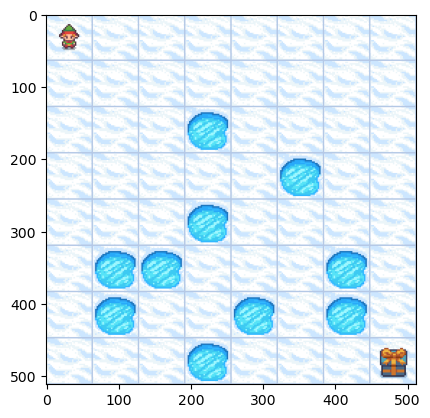

2


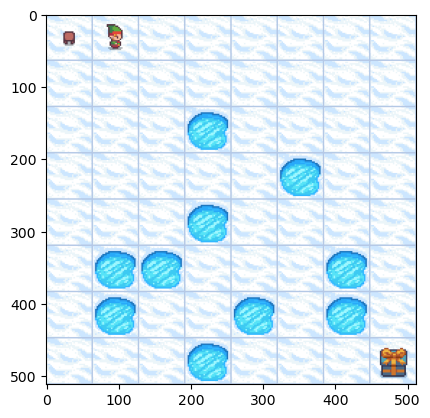

2


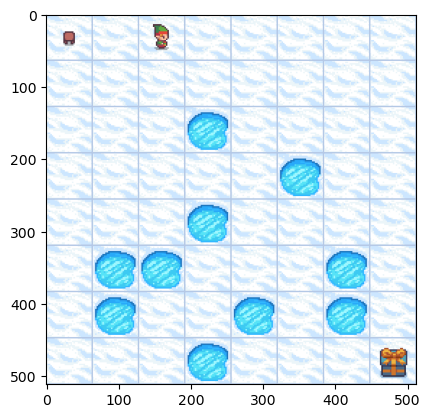

2


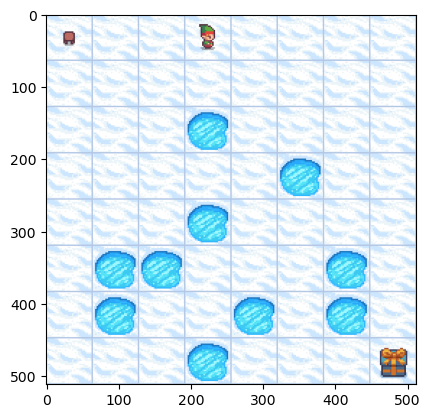

2


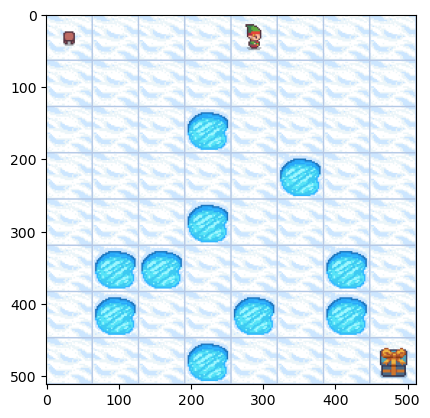

1


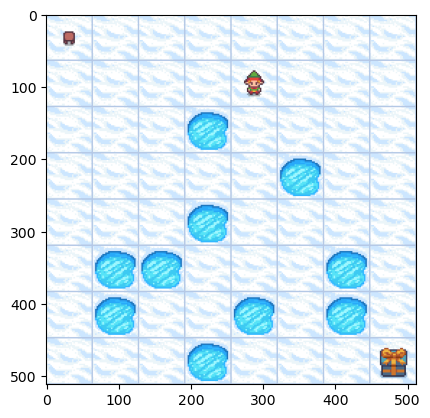

2


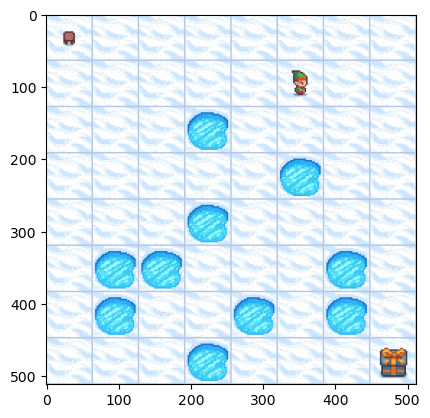

1


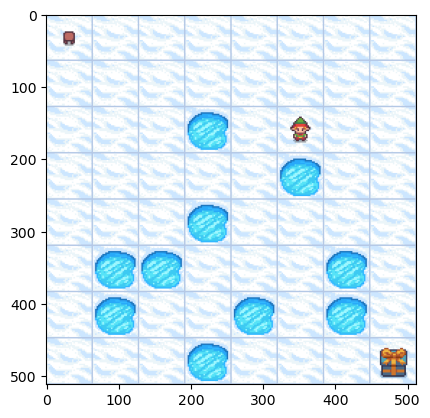

2


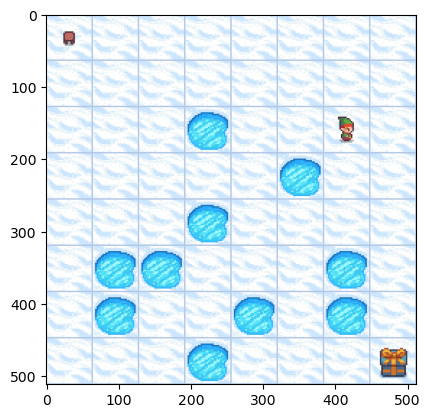

2


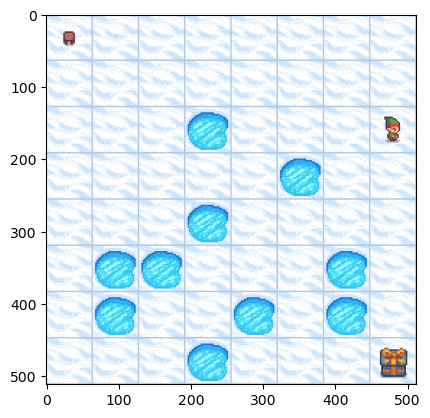

1


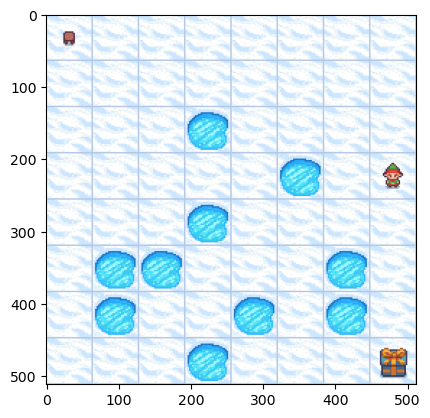

1


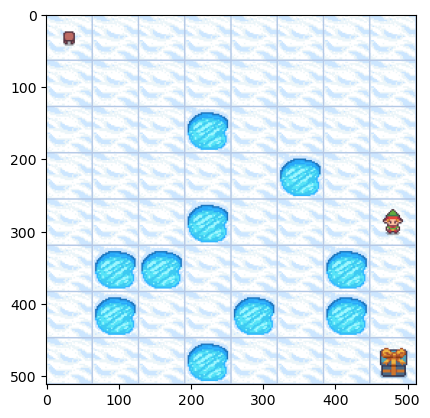

1


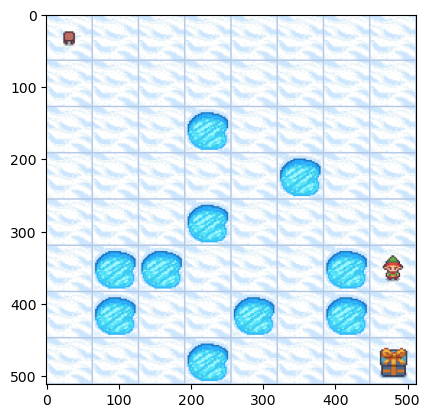

1


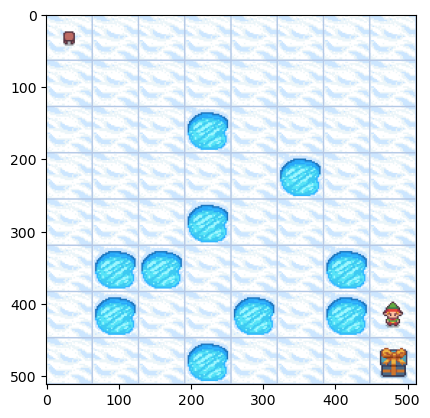

1
Total reward: 1.0 in 14 steps


In [31]:
def render_policy_execution(env, policy):
    state, info = env.reset()
    terminated, truncated = False, False
    total_reward = 0
    steps = 0

    while not (terminated or truncated):
        render()
        print(policy[state])
        action = policy[state]
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1

    print(f"Total reward: {total_reward} in {steps} steps")

render_policy_execution(env, policy_sarsa)

In [ ]:
policy[state]